### 문제 정의

- 패션 데이터를 이용해서 다중분류
- 전이학습

데이터 수집

In [1]:
from tensorflow.keras.datasets import fashion_mnist

(X_train,y_train),(X_test,y_test)= fashion_mnist.load_data()

X_train.shape, y_train.shape, X_test.shape,y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# 훈련데이터 1000개, 테스트 데이터 300개 샘플링
X_train=X_train[:1000,:]
y_train=y_train[:1000]
X_test=X_test[:300,:]
y_test=y_test[:300]
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1000, 28, 28), (1000,), (300, 28, 28), (300,))

In [5]:
import pandas as pd
pd.Series(y_train).unique()

array([9, 0, 3, 2, 7, 5, 1, 6, 4, 8], dtype=uint8)

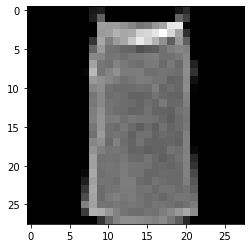

In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[377],cmap="gray")

In [11]:
y_train_en=pd.get_dummies(y_train)
y_test_en=pd.get_dummies(y_test)

y_train_en.shape,y_test_en.shape

((1000, 10), (300, 10))

이미지 전처리

In [13]:
#이미지를 (28,28)에서 (244,244) 크기로 변경
from PIL import Image
import numpy as np

train_resize_list=[]

for i in range(len(X_train)):
    train_resize_img=Image.fromarray(X_train[i]).resize((244,244))
    train_resize_list.append(np.array(train_resize_img))

In [14]:
test_resize_list=[]

for i in range(len(X_test)):
    test_resize_img=Image.fromarray(X_test[i]).resize((244,244))
    test_resize_list.append(np.array(test_resize_img))

In [15]:
#리스트를 numpy array
X_train_resized=np.array(train_resize_list)
X_test_resized=np.array(test_resize_list)

X_train_resized.shape,X_test_resized.shape

((1000, 244, 244), (300, 244, 244))

In [16]:
#색상 차원 추가
X_train_resized=X_train_resized.reshape(X_train_resized.shape[0],244,244,1)
X_test_resized=X_test_resized.reshape(X_test_resized.shape[0],244,244,1)

X_train_resized.shape,X_test_resized.shape

((1000, 244, 244, 1), (300, 244, 244, 1))

In [17]:
import numpy as np
import tensorflow as tf
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten

model=Sequential()

model.add(Conv2D(32,(3,3),input_shape=(244,244,1),
                activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),
                activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),
                activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(256,activation="relu"))
model.add(Dense(10,activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 242, 242, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 57, 57, 128)      

In [38]:
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(lr=0.0001),
             metrics=["acc"])

In [39]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#모델을 저장할 폴더명
MODEL_FOLDER="./model/"
#해당 폴더가 없다면 해당 폴더를 생성
if not os.path.exists(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
#저장할 파일명 설정
#{epoch:04d} : 반복수를 4자리로 표시
#{acc:.4f} : 정확도를 소수점 4째자리까지 표시
modelpath = MODEL_FOLDER+"fashion-{epoch:04d}-{val_acc:.4f}.hdf5"

#베스트를 찾아서 해당파일명으로 저장
#save_best_only : 더 나은 결과값만 저장
#ModelCheckpoint(filepath=파일패스,monitor=기준값,save_best_only=True/False)
mc=ModelCheckpoint(filepath=modelpath,
                  monitor="val_acc",
                   #회귀일 경우 monitor="loss"를 사용
                  save_best_only=True,
                  verbose=1)
# EarlyStopping(monitor=기준값, patience=조금 더 기다리는 횟수)
# patience=20 : 학습이 더 나아지지 않더라도 20회는 더 반복해줌
es = EarlyStopping(monitor="val_acc",patience=10)

#학습
h=model.fit(X_train_resized,y_train_en,epochs=30,batch_size=20,
                      validation_data=(X_test_resized,y_test_en),
                      callbacks=[mc,es])

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/50 [============================>.] - ETA: 0s - loss: 21.0279 - acc: 0.4714WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001CCBDD050D0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

50/50 [==============================] - 3s 53ms/step - loss: 0.0583 - acc: 0.9830 - val_loss: 0.5904 - val_acc: 0.8333
Epoch 22/30
49/50 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9898
Epoch 00022: val_acc did not improve from 0.83333
50/50 [==============================] - 2s 33ms/step - loss: 0.0373 - acc: 0.9900 - val_loss: 0.6160 - val_acc: 0.8200
Epoch 23/30
49/50 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9816
Epoch 00023: val_acc did not improve from 0.83333
50/50 [==============================] - 2s 33ms/step - loss: 0.0588 - acc: 0.9820 - val_loss: 0.6406 - val_acc: 0.8200
Epoch 24/30
49/50 [============================>.] - ETA: 0s - loss: 0.0463 - acc: 0.9837
Epoch 00024: val_acc did not improve from 0.83333
50/50 [==============================] - 2s 33ms/step - loss: 0.0456 - acc: 0.9840 - val_loss: 0.6466 - val_acc: 0.8067
Epoch 25/30
49/50 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9939
Epoch 0002

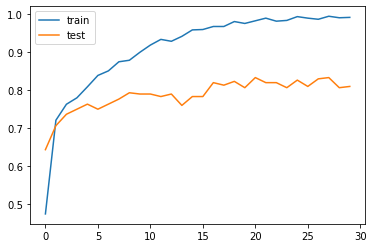

In [40]:
import matplotlib.pyplot as plt
plt.plot(h.history["acc"],label="train")
plt.plot(h.history["val_acc"],label="test")
plt.legend()

In [41]:
pred=model.predict(X_test_resized)

print(pred[0])
print(y_test[0])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[3.8583741e-07 3.5596418e-08 1.0644843e-06 4.8038332e-06 1.3891222e-05
 6.7191402e-04 4.4009780e-06 9.0758409e-03 4.8083917e-04 9.8974681e-01]
9


Xception을 이용한 전이학습

In [42]:
# 그레이 이미지 채널을 칼라이미지를 칼라이미지 채널(B,G,R) 변경
X_train_resized=np.repeat(X_train_resized,3,axis=3)
X_test_resized=np.repeat(X_test_resized,3,axis=3)

X_train_resized.shape,X_test_resized.shape

((1000, 244, 244, 3), (300, 244, 244, 3))

In [49]:
from tensorflow.keras.applications import Xception

conv_xception=Xception(include_top=False,
                      weights="imagenet",
                      input_shape=(244,244,3))
#Xception 모델의 파라미터 갱신을 못하게 함
conv_xception.trainable=True

In [55]:
model2=Sequential()

model2.add(conv_xception)
model2.add(Flatten())

model2.add(Dense(256,activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(10,activation="softmax"))

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_7 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33554688  
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
Total params: 54,418,738
Trainable params: 54,364,210
Non-trainable params: 54,528
_________________________________________________________________


In [56]:
model2.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(lr=0.0001),
             metrics=["acc"])

In [57]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#모델을 저장할 폴더명
MODEL_FOLDER="./model/"
#해당 폴더가 없다면 해당 폴더를 생성
if not os.path.exists(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
#저장할 파일명 설정
#{epoch:04d} : 반복수를 4자리로 표시
#{acc:.4f} : 정확도를 소수점 4째자리까지 표시
modelpath = MODEL_FOLDER+"fashion2-{epoch:04d}-{val_acc:.4f}.hdf5"

#베스트를 찾아서 해당파일명으로 저장
#save_best_only : 더 나은 결과값만 저장
#ModelCheckpoint(filepath=파일패스,monitor=기준값,save_best_only=True/False)
mc=ModelCheckpoint(filepath=modelpath,
                  monitor="val_acc",
                   #회귀일 경우 monitor="loss"를 사용
                  save_best_only=True,
                  verbose=1)
# EarlyStopping(monitor=기준값, patience=조금 더 기다리는 횟수)
# patience=20 : 학습이 더 나아지지 않더라도 20회는 더 반복해줌
es = EarlyStopping(monitor="val_acc",patience=10)

#학습
h2=model2.fit(X_train_resized,y_train_en,epochs=10,batch_size=20,
                      validation_data=(X_test_resized,y_test_en),
                      callbacks=[mc,es])

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
50/50 [==============================] - ETA: 0s - loss: 0.2190 - acc: 0.9350WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001CEB8587598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

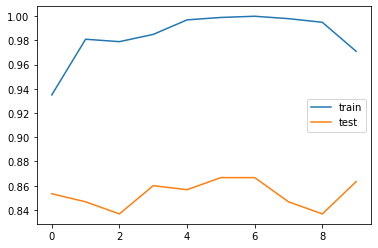

In [58]:
import matplotlib.pyplot as plt
plt.plot(h2.history["acc"],label="train")
plt.plot(h2.history["val_acc"],label="test")
plt.legend()